In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
import numpy as np
import gpflow
import gpflow as gpf
import tensorflow as tf
from gpflow.ci_utils import ci_niter
import time
from sklearn.metrics import r2_score
from typing import Dict, Optional, Tuple
import h5py
import random

np.random.seed(0)
rng = np.random.RandomState(123)
%matplotlib inline
plt.style.use("ggplot")

: 

: 

# Import data set

In [2]:
m1=h5py.File('X.mat','r')
X=m1['X'][:]
X=X.transpose()
X[:,2:]=X[:,2:]-1


m2=h5py.File('YN_SD0.4.mat','r')
Y=m2['Y'][:]
Y=Y.transpose()

# Normalize the output

In [3]:
ma=h5py.File('Y_min_SD0.4.mat','r')
Ymin=ma['Y_min'][:]
Ymin=Ymin.transpose()

mb=h5py.File('Yrange_SD0.4.mat','r')
Yrange=mb['Yrange'][:]
Yrange=Yrange.transpose()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1,test_size=0.1)

In [5]:
X_train.shape

(45000, 3)

In [18]:
X_train

array([[0.55555556, 0.73737374, 4.        ],
       [0.90909091, 0.21212121, 3.        ],
       [0.60606061, 0.44444444, 3.        ],
       ...,
       [0.51515152, 0.92929293, 0.        ],
       [0.21212121, 0.72727273, 1.        ],
       [0.3030303 , 0.03030303, 3.        ]])

# Problem definition

In [6]:
N = X_train.shape[0]  # number of points
D = 3  # number of input dimensions
M = 100  # number of inducing points
L = 1  # number of latent GPs
P = 1  # number of observations = output dimensions

# Kernel definition

In [7]:
class KernelWithEmbedding(gpf.kernels.Kernel):
    def __init__(
        self,
        input_shape: Tuple,
        input_dim: int,
        output_dim: int,
        kernels: gpf.kernels.Kernel,
        batch_size: Optional[int] = None,
    ):
        super().__init__()
        with self.name_scope:
            self.kernels = kernels
            self.input_shape = input_shape
            self.input_dim = input_dim
            self.output_dim = output_dim

            data_input = tf.keras.layers.Input(shape=input_shape,name='input')
            x = tf.keras.layers.Reshape((input_shape[0],1),input_shape=input_shape)(data_input)
            x1= tf.keras.layers.Cropping1D(cropping=(0,1))(x) # quantitative input
            x2= tf.keras.layers.Cropping1D(cropping=(2,0))(x) # qualitative input
            # if you have more than one qualitative inputs:
            #x2= tf.keras.layers.Cropping1D(cropping=(2,1))(x)
            #x3= tf.keras.layers.Cropping1D(cropping=(3,0))(x)
            
            x2= tf.keras.layers.Embedding(self.input_dim, self.output_dim)(x2) # map qualittaive input to latent space
            # if you have more than one qualitative inputs:
            # x2= tf.keras.layers.Embedding(self.input_dim[0], self.output_dim)(x2)
            # x3= tf.keras.layers.Embedding(self.input_dim[1], self.output_dim)(x3)
            
            x1=tf.keras.layers.Reshape((2,))(x1) # Reshape((dim of x1,))(x1)
            x2=tf.keras.layers.Reshape((2,))(x2)  # Reshape((dim of latent space for x2,))(x2)

            output=tf.keras.layers.concatenate([x1,x2],axis=1,dtype='float64')
            # if you have more than one qualitative inputs:
            #output=tf.keras.layers.concatenate([x1,x2,x3],axis=1,dtype='float64')

            self.emb= tf.keras.models.Model(data_input , output)

    def K(self, a_input: tf.Tensor, b_input: Optional[tf.Tensor] = None) -> tf.Tensor:
        transformed_a = tf.squeeze(self.emb(a_input))
        transformed_b = tf.squeeze(self.emb(b_input)) if b_input is not None else b_input
        return self.kernels.K(transformed_a, transformed_b)

    def K_diag(self, a_input: tf.Tensor) -> tf.Tensor:
        transformed_a = tf.squeeze(self.emb(a_input))
        return self.kernels.K_diag(transformed_a)

In [8]:
from gpflow.inducing_variables import (
    FallbackSeparateIndependentInducingVariables,
    FallbackSharedIndependentInducingVariables,
    InducingPoints,
    SeparateIndependentInducingVariables,
    SharedIndependentInducingVariables,
)


@gpflow.covariances.Kuu.register(InducingPoints, KernelWithEmbedding)
def Kuu(inducing_variable:InducingPoints, kernel:KernelWithEmbedding, jitter=None):
    return gpf.covariances.Kuu(inducing_variable, kernel.kernels,jitter=jitter)


@gpflow.covariances.Kuf.register(InducingPoints, KernelWithEmbedding, object)
def Kuf(inducing_variable:InducingPoints, kernel:KernelWithEmbedding, Xnew):
    return gpf.covariances.Kuf(inducing_variable, kernel.kernels, kernel.emb(Xnew))

# Instantialize the model

In [9]:
dim_z=2
ind_qual=[2]
n_lvs_qual=[5]
p_qual=1
kernel_t=gpf.kernels.SquaredExponential(active_dims=[0])*gpf.kernels.SquaredExponential(active_dims=[1])*gpf.kernels.SquaredExponential(active_dims=range(2,4)) 
kernel=KernelWithEmbedding((3,),n_lvs_qual[0],2,kernel_t) 
arr = np.arange(N)
np.random.shuffle(arr)
Z_o = X_train[arr[:M], :].copy()  # Initialize inducing locations to the first M inputs in the dataset
Zinit=kernel.emb(Z_o).numpy()
Z = Zinit.copy()

In [10]:
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)

In [11]:
m

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.emb._layers[4]._trainable_weights[0] SVGP.kernel.emb._layers[4].embeddings,ResourceVariable,,,True,"(5, 2)",float32,"[[-0.03860753, 0.03171755..."
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(100, 4)",float64,"[[0.97979796, 0.64646465, -0.03860753..."
SVGP.q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[0....


# Training

In [12]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat().shuffle(N)

train_iter = iter(train_dataset.batch(minibatch_size))

In [13]:
import gpflow 
minibatch_size = 100

# We turn off training for inducing point locations
gpflow.set_trainable(m.inducing_variable, True)
# gpflow.set_trainable(m.z_vec, True)
gpflow.set_trainable(m.kernel.kernels.kernels[1].variance,False)
gpflow.set_trainable(m.kernel.kernels.kernels[2].variance,False)

gpflow.set_trainable(m.q_mu, False)
gpflow.set_trainable(m.q_sqrt, False)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    natgrad_adam_opt = tf.optimizers.Adam()
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    variational_params = [(model.q_mu, model.q_sqrt)]

    @tf.function
    def optimization_step():
        natgrad_adam_opt.minimize(training_loss, model.trainable_variables)
        natgrad_opt.minimize(training_loss, var_list=variational_params)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

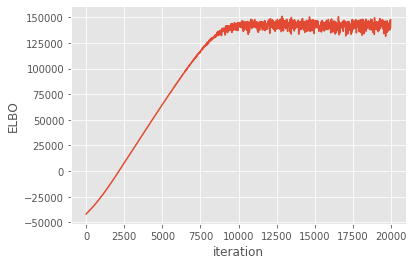

In [14]:
import time
maxiter = ci_niter(20000)

time_start=time.time()
logf = run_adam(m, maxiter)
time_end=time.time()
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
pY, pYv = m.predict_y(X_test)
YtR= y_test*np.tile(Yrange,( y_test.shape[0],1))+np.tile(Ymin,( y_test.shape[0],1))
pYR=pY*np.tile(Yrange,(pY.shape[0],1))+np.tile(Ymin,(pY.shape[0],1))
r2_score(YtR,pYR,multioutput='raw_values')
np.sqrt(mean_squared_error(YtR,pYR))

0.4234600096061353